In [1]:
!wget -O imdb.zip --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip install eli5
!pip install spacy
!python -m spacy download en

--2022-08-25 16:15:13--  https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc
Resolving drive.google.com (drive.google.com)... 173.194.222.194
Connecting to drive.google.com (drive.google.com)|173.194.222.194|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2s6kr4q551c8l0mvjqa0e4bq7sqehp9f/1661433300000/14571764687846983170/*/1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc?e=download&uuid=9554a523-a8f4-4f8e-ba2b-1b4e8eb5bf0a [following]
--2022-08-25 16:15:17--  https://doc-14-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2s6kr4q551c8l0mvjqa0e4bq7sqehp9f/1661433300000/14571764687846983170/*/1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc?e=download&uuid=9554a523-a8f4-4f8e-ba2b-1b4e8eb5bf0a
Resolving doc-14-6k-docs.googleusercontent.com (doc-14-6k-docs.googleusercontent.com)... 64.233.165.132
Connecting to doc-14-6k-docs.googleuserco

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [14]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
vectorizer = CountVectorizer()
lr_X = vectorizer.fit_transform(train_df['review'])

In [19]:
lr_y = train_df['is_positive']

In [86]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(max_iter=10000)
lr.fit(lr_X, lr_y)

LogisticRegression(max_iter=10000)

In [87]:
from sklearn.metrics import f1_score


f1_score(lr_y, lr.predict(lr_X))

0.9983197311569851

In [96]:
importancies = pd.DataFrame()
importancies['word'] = vectorizer.get_feature_names_out()
importancies['importance'] = lr.coef_[0]
pos_words = importancies.sort_values('importance', ascending=False).head(50).to_numpy()[:,0].tolist()
neg_words = importancies.sort_values('importance', ascending=False).tail(50).to_numpy()[:,0].tolist()
importancies.sort_values('importance', ascending=False)

,word,importance
54378,refreshing,1.585565
73498,wonderfully,1.414683
22369,erotic,1.345474
26380,funniest,1.291780
22912,excellent,1.288100
...,...,...
37435,lacks,-1.714635
50821,poorly,-1.826194
18642,disappointment,-2.105992
72229,waste,-2.120392


In [97]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = ['love', 'great', 'best', 'wonderful', 'reccommend'] + pos_words #@param {type:"raw"}
negative_words = ['worst', 'awful', '1/10', 'crap', 'evilest'] + neg_words #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 72.20%


HTTPError: HTTP Error 404: Not Found

**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [103]:
import re

pattern = re.compile('<br />')

# print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...  I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...  THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".  THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.  THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one step further and say that they actually 

Применим ее:

In [104]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [106]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [107]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [108]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [110]:
model.fit(train_df['review'], train_df['is_positive'])

/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [111]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.48%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [112]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.877,refreshing
+1.767,wonderfully
+1.695,funniest
+1.654,surprisingly
+1.627,rare
+1.437,excellent
+1.415,superb
+1.361,incredible
+1.355,perfect
+1.316,delightful


Посмотрим на конкретные примеры его работы:

In [113]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [114]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [115]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [117]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [118]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.86%


In [119]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [148]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [151]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls O 
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faithful

Не понял задание :/

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [136]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


In [137]:
from nltk import word_tokenize

In [142]:
def prepare_text(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

prepare_text('I have become lost for a while')

'i have becom lost for a while'

In [143]:
train_df['prepared_review'] = train_df['review'].apply(prepare_text)
train_df

,is_positive,review,prepared_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,i simpli love thi movi . i also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call them that .....
4,1,My all-time favorite movie! I have seen many m...,my all-tim favorit movi ! i have seen mani mov...
...,...,...,...
24995,1,"I am a big fan of the movie, but not for the u...","i am a big fan of the movi , but not for the u..."
24996,0,I'm not going to bother with a plot synopsis s...,i 'm not go to bother with a plot synopsi sinc...
24997,0,This movie . . . I don't know. Why they would ...,thi movi . . . i do n't know . whi they would ...
24998,1,Saw this film on DVD yesterday and was gob-sma...,saw thi film on dvd yesterday and wa gob-smack...


In [144]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['prepared_review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.17%


**Задание** Попробуйте вместо лемм классифицировать основы.

Какие еще основы? И как я их должен экстрактить? Вам бы основы составления ТЗ выучить :/

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [26]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

В закрепленных файлах нету сущностей и их координат :/

In [154]:
prepared_reviews_2 = []
for doc in docs:
    new_doc = []
    for token in docs[0]:
        if token.ent_type_ == '':
            new_doc.append(token.text)
    prepared_reviews_2.append(' '.join(new_doc))

In [158]:
docs_2 = [doc for doc in nlp.pipe(prepared_reviews_2)]

In [159]:
displacy.render(docs_2[0], style='ent', jupyter=True)

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [160]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<BarContainer object of 231 artists>

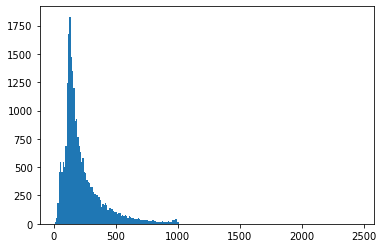

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [162]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [163]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

/var/folders/fm/c7ljnhr1431byzjw21b2hzy00000gn/T/ipykernel_97995/1263189772.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
/var/folders/fm/c7ljnhr1431byzjw21b2hzy00000gn/T/ipykernel_97995/1263189772.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [164]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [165]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [166]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-25 18:05:15.676291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 18:05:15.679547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
______________________________________________

In [167]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10


2022-08-25 18:05:25.891967: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-25 18:05:26.728840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7438

2022-08-25 18:05:41.623756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 18s 81ms/step - loss: 0.5795 - accuracy: 0.7438 - val_loss: 0.3759 - val_accuracy: 0.8413
Epoch 2/10
196/196 [==============================] - 10s 52ms/step - loss: 0.2771 - accuracy: 0.8887 - val_loss: 0.2982 - val_accuracy: 0.8739
Epoch 3/10
196/196 [==============================] - 11s 55ms/step - loss: 0.1604 - accuracy: 0.9426 - val_loss: 0.3004 - val_accuracy: 0.8752
Epoch 4/10
196/196 [==============================] - 10s 49ms/step - loss: 0.0828 - accuracy: 0.9766 - val_loss: 0.3295 - val_accuracy: 0.8735
Epoch 5/10
196/196 [==============================] - 9s 48ms/step - loss: 0.0354 - accuracy: 0.9940 - val_loss: 0.3741 - val_accuracy: 0.8700
Epoch 6/10
196/196 [==============================] - 10s 53ms/step - loss: 0.0141 - accuracy: 0.9984 - val_loss: 0.4108 - val_accuracy: 0.8698
Epoch 7/10
196/196 [==============================] - 10s 50ms/step - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.4421 - val_accuracy: 0.8698
Epoc

**Задание** Подсчитайте качество модели на тесте

Эм, как бы тест передан через аргрумент `validation_data` и в выводе печатается val_accuracy. А будет ли потом разбор ДЗ?